In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from scipy.optimize import minimize

# Funcions and plots

In [2]:
def f1(x1 : float, y1 : float) -> float:
    return (x1**2 + y1 - 11)**2 + (x1 + y1**2 - 7)**2

In [3]:
def f2(x2 : float, y2 : float) -> float:
    return 2*x2**2 + 1.05*x2**4 + (x2**6)/6 + x2*y2 + y2**2

In [4]:
def f1_wrapper(x):
    x1, y1 = x[0], x[1]
    return f1(x1, y1)

In [5]:
def f2_wrapper(x):
    x2, y2 = x[0], x[1]
    return f2(x2, y2)

In [6]:
def find_minima_in_bounds(f_wrapper, x_bounds, y_bounds, number_of_points = 100) -> list:
    x = np.linspace(x_bounds[0], x_bounds[1], int(np.sqrt(number_of_points)))
    y = np.linspace(y_bounds[0], y_bounds[1], int(np.sqrt(number_of_points)))
    linespace_grid = np.array(np.meshgrid(x, y)).T.reshape(-1, 2)
    mins = []
    for point in linespace_grid:
        minimum = minimize(f_wrapper, point, bounds=[x_bounds, y_bounds])
        minimum = (round(minimum.x[0], 2), round(minimum.x[1], 2), round(minimum.fun, 2))
        mins.append(minimum)
    mins = set(mins)
    mins = sorted(mins, key=lambda x: x[2])
    return mins

In [7]:
def plot_function(function, wrapper, x_range, y_range, title, num_contours=50):
    x = np.linspace(x_range[0], x_range[1], 100)
    y = np.linspace(y_range[0], y_range[1], 100)
    X, Y = np.meshgrid(x, y)
    Z = function(X, Y)

    fig = plt.figure(figsize=(15, 6))

    # Plot 3D
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none', alpha=0.8, antialiased=True, shade=True)
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('Z')
    ax1.set_title(title)
    ax1.grid(True)

    # Contours (Top view)
    ax2 = fig.add_subplot(122)
    contour = ax2.contour(X, Y, Z, num_contours, colors='k', linestyles='dashed')
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.set_title(title + " - Contours (Top view)")

    # find all mins
    mins = find_minima_in_bounds(wrapper, x_range, y_range)
    if mins:
        global_min = mins[0]
        ax2.plot(global_min[0], global_min[1], 'r*', markersize=10, label=f"Global min (Z = {global_min[2]})")
        local_mins = mins[1:]
        for local_min in local_mins:
            ax2.plot(local_min[0], local_min[1], 'g*', markersize=10, label=f"Local min (Z = {local_min[2]})")

    ax2.legend()

    plt.tight_layout()
    plt.show()

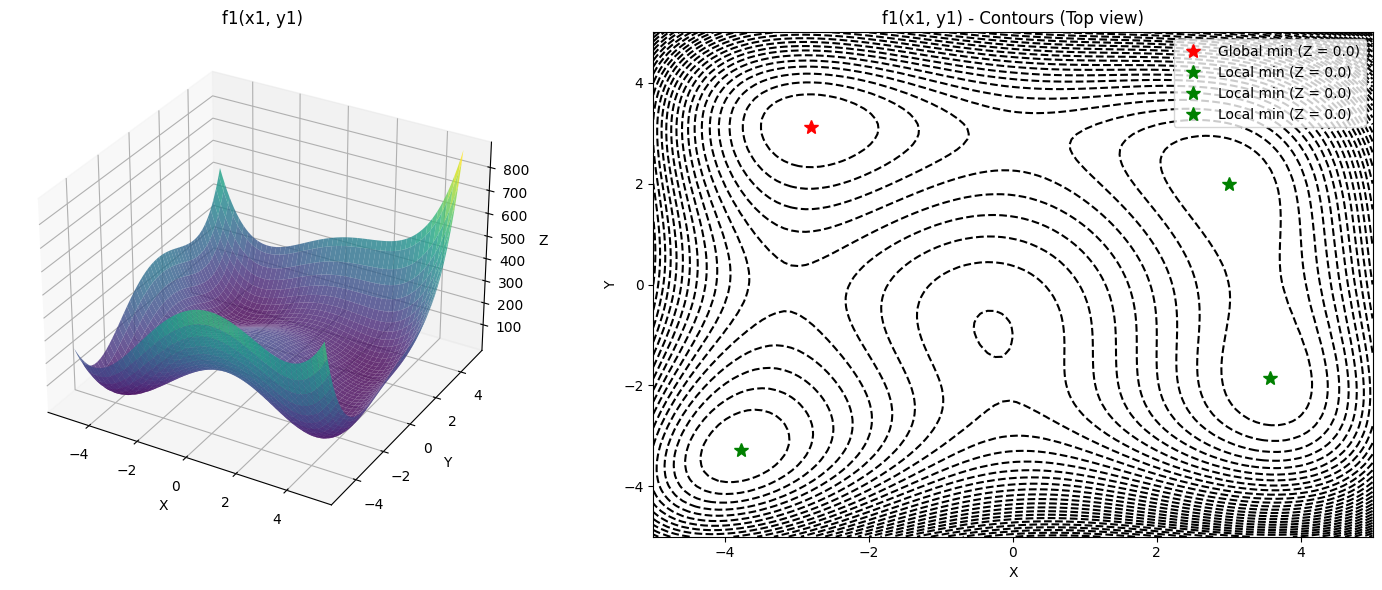

In [8]:
plot_function(f1, f1_wrapper, [-5, 5], [-5, 5], 'f1(x1, y1)')

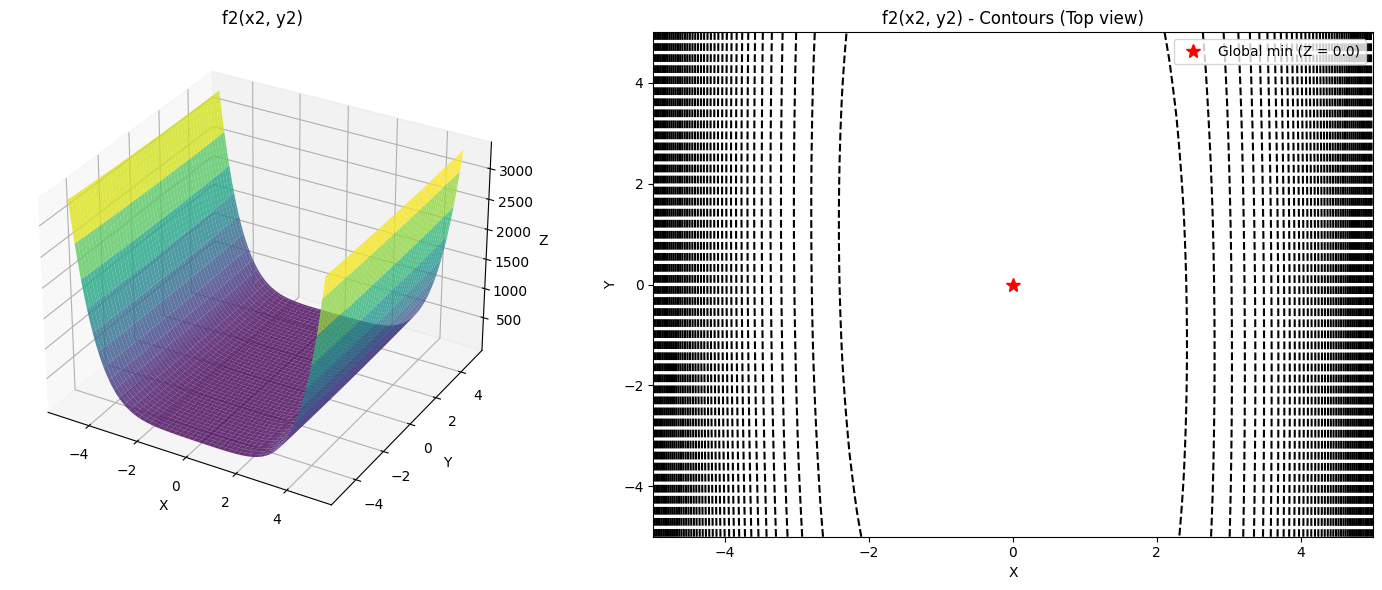

In [9]:
plot_function(f2, f2_wrapper, [-5, 5], [-5, 5], 'f2(x2, y2)')

# Implementation of evolutionary algorithm

In [33]:
def fitness_function(entity, range, penalty):
    x1, y1, x2, y2 = entity.chromosome
    result = f1(x1, y1) + f2(x2, y2)
    if any([x1 < range[0], x1 > range[1], y1 < range[0], y1 > range[1], x2 < range[0], x2 > range[1], y2 < range[0], y2 > range[1]]):
        result += penalty
    return result

In [34]:
class Entity:
    def __init__(self, f_range):
        self.result = None
        self.chromosome = np.zeros(4)
        self.initialize_random_chromosome(f_range)

    def initialize_random_chromosome(self, f_range):
        self.chromosome[0] = np.random.uniform(f_range[0], f_range[1])
        self.chromosome[1] = np.random.uniform(f_range[0], f_range[1])
        self.chromosome[2] = np.random.uniform(f_range[0], f_range[1])
        self.chromosome[3] = np.random.uniform(f_range[0], f_range[1])

    def set_chromosome_values(self, x1, y1, x2, y2):
        self.chromosome[0] = x1
        self.chromosome[1] = y1
        self.chromosome[2] = x2
        self.chromosome[3] = y2

    def __str__(self) -> str:
        return f"Entity: {self.chromosome}, Fitness: {self.result}"

In [35]:
class Population:
    def __init__(self, f_range, population_size):
        self.population_size = population_size
        self.entities = []
        self.best_entity = None
        self.function_range = f_range
        self.initialize_population()

    def initialize_population(self):
        for _ in range(self.population_size):
            self.entities.append(Entity(self.function_range))

    def evaluate_population(self, penalty):
        for entity in self.entities:
            entity.result = fitness_function(entity, self.function_range, penalty)
        self.entities = sorted(self.entities, key=lambda entity: entity.result)

    def find_best_entity(self):
        self.best_entity = min(self.entities, key=lambda entity: entity.result)

    def __str__(self) -> str:
        result = ""
        for entity in self.entities:
            result += str(entity) + "\n"
        return result

In [36]:
class EvolutionaryAlgorithm:
    def __init__(self,
                 fitness_function : callable,
                 population : Population,
                 max_time : int,
                 penalty : int,
                 mutation_rate : float,
                 mutation_range : float,
                 crossover_rate : float):

        self.fitness_function = fitness_function
        self.population = population
        self.max_time = max(max_time, 0)
        self.penalty = penalty
        self.mutation_rate = mutation_rate
        self.mutation_range = mutation_range
        self.crossover_rate = crossover_rate
        self.best_entity = None

    def tournament_selection(self):
        new_generation = []
        for entity in self.population.entities:
            opponent = np.random.choice(self.population.entities)
            if entity.result < opponent.result:
                new_generation.append(entity)
            else:
                new_generation.append(opponent)
        self.population.entities = new_generation

    def gaussian_mutation(self):
        for entity in self.population.entities:
            for i in range(len(entity.chromosome)):
                if np.random.uniform(0, 1) < self.mutation_rate:
                    entity.chromosome[i] += np.random.normal(-self.mutation_range, self.mutation_range)

    def crossover(self):
        new_generation = []
        for entity in self.population.entities:
            if np.random.uniform(0, 1) < self.crossover_rate:
                partner = np.random.choice(self.population.entities)
                child = Entity(self.population.function_range)
                child.set_chromosome_values(entity.chromosome[0], partner.chromosome[1], partner.chromosome[2], entity.chromosome[3])
                new_generation.append(child)
            else:
                new_generation.append(entity)
        self.population.entities = new_generation

    def run_algorithm(self):
        self.population.evaluate_population(self.penalty)
        self.population.find_best_entity()
        self.best_entity = self.population.best_entity
        while self.max_time > 0:
            self.tournament_selection()
            self.gaussian_mutation()
            self.crossover()
            self.population.evaluate_population(self.penalty)
            self.population.find_best_entity()
            if self.population.best_entity.result < self.best_entity.result:
                self.best_entity = self.population.best_entity
            self.max_time -= 1
        return self.best_entity

In [111]:
start_population = Population([-5, 5], 30)
max_time = 500
penalty = 10000
mutation_rate = 0.03
mutation_range = 1
crossover_rate = 0.95

algorthm = EvolutionaryAlgorithm(fitness_function, start_population, max_time, penalty, mutation_rate, mutation_range, crossover_rate)
best_entity = algorthm.run_algorithm()
print("Best Entity:")
print(best_entity)
print("Final population:")
print(algorthm.population)

Best Entity:
Entity: [ 3.59905914 -1.86848638  0.0086644   0.0067245 ], Fitness: 0.01558873906374613
Final population:
Entity: [ 3.59905914 -1.83303167  0.0086644  -0.01027627], Fitness: 0.016289298527083867
Entity: [ 3.59905914 -1.83303167  0.0086644  -0.01027627], Fitness: 0.016289298527083867
Entity: [ 3.59905914 -1.83303167  0.0086644  -0.01027627], Fitness: 0.016289298527083867
Entity: [ 3.59905914 -1.83303167  0.0086644  -0.01027627], Fitness: 0.016289298527083867
Entity: [ 3.59905914 -1.83303167  0.0086644  -0.01027627], Fitness: 0.016289298527083867
Entity: [ 3.59905914 -1.83303167  0.0086644  -0.01027627], Fitness: 0.016289298527083867
Entity: [ 3.59905914 -1.83303167  0.0086644  -0.01027627], Fitness: 0.016289298527083867
Entity: [ 3.59905914 -1.83303167  0.0086644  -0.01027627], Fitness: 0.016289298527083867
Entity: [ 3.59905914 -1.83303167  0.0086644  -0.01027627], Fitness: 0.016289298527083867
Entity: [ 3.59905914 -1.83303167  0.0086644  -0.01027627], Fitness: 0.0162892985